In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 128

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 128)   768         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 128)   512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 128)   768         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 128)   512         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 128)   0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 128)   768         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 128)   512         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1144 - acc: 0.4182
Epoch 00001: val_loss improved from inf to 1.39507, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_4_conv_checkpoint/001-1.3951.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 2.1144 - acc: 0.4181 - val_loss: 1.3951 - val_acc: 0.5590
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3175 - acc: 0.6160
Epoch 00002: val_loss did not improve from 1.39507
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.3175 - acc: 0.6161 - val_loss: 1.5006 - val_acc: 0.5658
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0813 - acc: 0.6844
Epoch 00003: val_loss improved from 1.39507 to 1.19747, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_4_conv_checkpo

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1293 - acc: 0.9589
Epoch 00028: val_loss did not improve from 0.94536
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1293 - acc: 0.9589 - val_loss: 1.4887 - val_acc: 0.7347
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1312 - acc: 0.9585
Epoch 00029: val_loss did not improve from 0.94536
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1312 - acc: 0.9585 - val_loss: 1.1213 - val_acc: 0.7864
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1149 - acc: 0.9638
Epoch 00030: val_loss did not improve from 0.94536
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1149 - acc: 0.9638 - val_loss: 1.2397 - val_acc: 0.7727
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1191 - acc: 0.9643
Epoch 00031: val_loss did not improve from 0.94536
36805/36805 [========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0706 - acc: 0.9802
Epoch 00058: val_loss did not improve from 0.94536
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0706 - acc: 0.9802 - val_loss: 1.1463 - val_acc: 0.8022
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0587 - acc: 0.9842
Epoch 00059: val_loss did not improve from 0.94536
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0587 - acc: 0.9842 - val_loss: 1.2574 - val_acc: 0.7908
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0612 - acc: 0.9828
Epoch 00060: val_loss did not improve from 0.94536
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0612 - acc: 0.9828 - val_loss: 1.3822 - val_acc: 0.7831
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0532 - acc: 0.9856
Epoch 00061: val_loss did not improve from 0.94536
36805/36805 [========

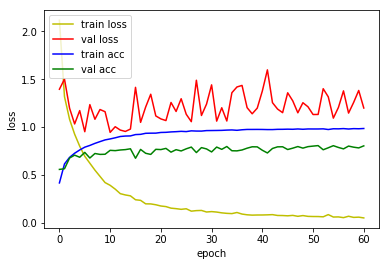

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.1085 - acc: 0.7113
Loss: 1.1085146523957932 Accuracy: 0.7113188

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9517 - acc: 0.4331
Epoch 00001: val_loss improved from inf to 1.46340, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_5_conv_checkpoint/001-1.4634.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 1.9516 - acc: 0.4331 - val_loss: 1.4634 - val_acc: 0.5460
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1818 - acc: 0.6445
Epoch 00002: val_loss improved from 1.46340 to 0.95416, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_5_conv_checkpoint/002-0.9542.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 1.1817 - acc: 0.6445 - val_loss: 0.9542 - val_acc: 0.7065
Epoch 3/500
36800/36805 [================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1473 - acc: 0.9526
Epoch 00026: val_loss did not improve from 0.48821
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1473 - acc: 0.9526 - val_loss: 0.5008 - val_acc: 0.8803
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1461 - acc: 0.9522
Epoch 00027: val_loss did not improve from 0.48821
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1460 - acc: 0.9522 - val_loss: 0.5862 - val_acc: 0.8640
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1384 - acc: 0.9549
Epoch 00028: val_loss did not improve from 0.48821
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1385 - acc: 0.9548 - val_loss: 0.5147 - val_acc: 0.8768
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1415 - acc: 0.9550
Epoch 00029: val_loss did not improve from 0.48821
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0570 - acc: 0.9831
Epoch 00056: val_loss did not improve from 0.48821
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0571 - acc: 0.9831 - val_loss: 0.5649 - val_acc: 0.8852
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0675 - acc: 0.9789
Epoch 00057: val_loss did not improve from 0.48821
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0675 - acc: 0.9789 - val_loss: 0.5841 - val_acc: 0.8807
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0562 - acc: 0.9828
Epoch 00058: val_loss did not improve from 0.48821
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0562 - acc: 0.9828 - val_loss: 0.5862 - val_acc: 0.8817
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9830
Epoch 00059: val_loss did not improve from 0.48821
36805/36805 [========

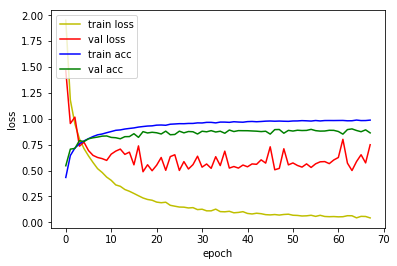

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.5634 - acc: 0.8494
Loss: 0.5634216163760034 Accuracy: 0.8494289

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8409 - acc: 0.4450
Epoch 00001: val_loss improved from inf to 1.29598, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_6_conv_checkpoint/001-1.2960.hdf5
36805/36805 [==============================] - 116s 3ms/sample - loss: 1.8410 - acc: 0.4450 - val_loss: 1.2960 - val_acc: 0.5835
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0296 - acc: 0.6819
Epoch 00002: val_loss improved from 1.29598 to 0.82094, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_6_conv_checkpoint/002-0.8209.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.0295 - acc: 0.6819 - val_loss: 0.8209 - val_acc: 0.7727
Epoch 3/500
36800/36805 [================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1000 - acc: 0.9681
Epoch 00026: val_loss did not improve from 0.27479
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0999 - acc: 0.9681 - val_loss: 0.3019 - val_acc: 0.9224
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0895 - acc: 0.9708
Epoch 00027: val_loss improved from 0.27479 to 0.26544, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_6_conv_checkpoint/027-0.2654.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0896 - acc: 0.9707 - val_loss: 0.2654 - val_acc: 0.9348
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0904 - acc: 0.9707
Epoch 00028: val_loss did not improve from 0.26544
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0904 - acc: 0.9707 - val_loss: 0.2878 - val_acc: 0.9322
Epoch 29/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9858
Epoch 00055: val_loss did not improve from 0.26544
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0438 - acc: 0.9858 - val_loss: 0.3006 - val_acc: 0.9387
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0328 - acc: 0.9901
Epoch 00056: val_loss did not improve from 0.26544
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0328 - acc: 0.9901 - val_loss: 0.2975 - val_acc: 0.9425
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9896
Epoch 00057: val_loss did not improve from 0.26544
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0309 - acc: 0.9896 - val_loss: 0.3848 - val_acc: 0.9194
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9901
Epoch 00058: val_loss did not improve from 0.26544
36805/36805 [=====================

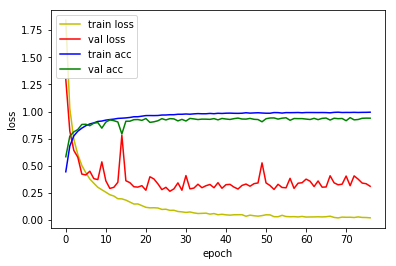

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3215 - acc: 0.9161
Loss: 0.32147054653672785 Accuracy: 0.91609555

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7262 - acc: 0.4736
Epoch 00001: val_loss improved from inf to 1.09679, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_7_conv_checkpoint/001-1.0968.hdf5
36805/36805 [==============================] - 121s 3ms/sample - loss: 1.7261 - acc: 0.4737 - val_loss: 1.0968 - val_acc: 0.6585
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7944 - acc: 0.7542
Epoch 00002: val_loss improved from 1.09679 to 0.51600, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_7_conv_checkpoint/002-0.5160.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.7943 - acc: 0.7542 - val_loss: 0.5160 - val_acc: 0.8532
Epoch 3/500
36800/36805 [==============

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9844
Epoch 00026: val_loss did not improve from 0.16042
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0500 - acc: 0.9844 - val_loss: 0.2988 - val_acc: 0.9234
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0522 - acc: 0.9832
Epoch 00027: val_loss did not improve from 0.16042
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0524 - acc: 0.9832 - val_loss: 0.1812 - val_acc: 0.9532
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0556 - acc: 0.9818
Epoch 00028: val_loss improved from 0.16042 to 0.14167, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_7_conv_checkpoint/028-0.1417.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0556 - acc: 0.9818 - val_loss: 0.1417 - val_acc: 0.9625
Epoch 29/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9889
Epoch 00055: val_loss improved from 0.14167 to 0.14117, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_7_conv_checkpoint/055-0.1412.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0351 - acc: 0.9889 - val_loss: 0.1412 - val_acc: 0.9679
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9957
Epoch 00056: val_loss did not improve from 0.14117
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0134 - acc: 0.9957 - val_loss: 0.1473 - val_acc: 0.9653
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9951
Epoch 00057: val_loss did not improve from 0.14117
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0150 - acc: 0.9951 - val_loss: 0.2251 - val_acc: 0.9574
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9968
Epoch 00084: val_loss did not improve from 0.14117
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0099 - acc: 0.9968 - val_loss: 0.3114 - val_acc: 0.9394
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.9965
Epoch 00085: val_loss did not improve from 0.14117
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0106 - acc: 0.9965 - val_loss: 0.1681 - val_acc: 0.9655
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9976
Epoch 00086: val_loss did not improve from 0.14117
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0084 - acc: 0.9975 - val_loss: 0.1929 - val_acc: 0.9632
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0186 - acc: 0.9942
Epoch 00087: val_loss did not improve from 0.14117
36805/36805 [=====================

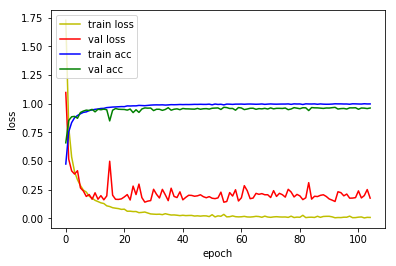

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2067 - acc: 0.9512
Loss: 0.20666624847122567 Accuracy: 0.95119417

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5003 - acc: 0.5481
Epoch 00001: val_loss improved from inf to 1.00943, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_8_conv_checkpoint/001-1.0094.hdf5
36805/36805 [==============================] - 123s 3ms/sample - loss: 1.5003 - acc: 0.5480 - val_loss: 1.0094 - val_acc: 0.6834
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6053 - acc: 0.8123
Epoch 00002: val_loss improved from 1.00943 to 0.34519, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_8_conv_checkpoint/002-0.3452.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.6053 - acc: 0.8123 - val_loss: 0.3452 - val_acc: 0.8919
Epoch 3/500
36800/36805 [==============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9850
Epoch 00026: val_loss improved from 0.13217 to 0.12649, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_BN_8_conv_checkpoint/026-0.1265.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0455 - acc: 0.9850 - val_loss: 0.1265 - val_acc: 0.9646
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9866
Epoch 00027: val_loss did not improve from 0.12649
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0413 - acc: 0.9866 - val_loss: 0.1537 - val_acc: 0.9623
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9921
Epoch 00028: val_loss did not improve from 0.12649
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0277 - acc: 0.9921 - val_loss: 0.1476 - val_acc: 0.9634
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9969
Epoch 00055: val_loss did not improve from 0.12271
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0112 - acc: 0.9969 - val_loss: 0.2231 - val_acc: 0.9546
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9958
Epoch 00056: val_loss did not improve from 0.12271
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0137 - acc: 0.9958 - val_loss: 0.1489 - val_acc: 0.9637
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9963
Epoch 00057: val_loss did not improve from 0.12271
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0126 - acc: 0.9963 - val_loss: 0.1572 - val_acc: 0.9679
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9970
Epoch 00058: val_loss did not improve from 0.12271
36805/36805 [========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0079 - acc: 0.9973
Epoch 00085: val_loss did not improve from 0.12271
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0079 - acc: 0.9973 - val_loss: 0.1466 - val_acc: 0.9700
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0058 - acc: 0.9983
Epoch 00086: val_loss did not improve from 0.12271
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0058 - acc: 0.9983 - val_loss: 0.2079 - val_acc: 0.9623
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9969
Epoch 00087: val_loss did not improve from 0.12271
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0090 - acc: 0.9969 - val_loss: 0.1781 - val_acc: 0.9623
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9968
Epoch 00088: val_loss did not improve from 0.12271
36805/36805 [========

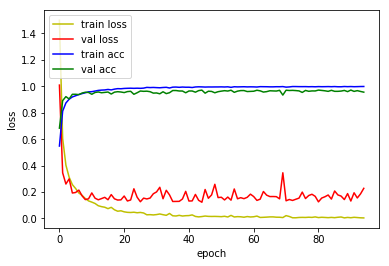

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1584 - acc: 0.9589
Loss: 0.15838427865705604 Accuracy: 0.9588785



In [10]:
base = '1D_CNN_custom_multi_2_concat_ch_128_DO_BN'

for i in range(4, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_concat_ch_128_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_concat_ch_128_DO_BN_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_33[0][0]  
_____________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.5634 - acc: 0.8494
Loss: 0.5634216163760034 Accuracy: 0.8494289

1D_CNN_custom_multi_2_concat_ch_128_DO_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_42 (Batc (None, 16000, 128)   512         conv1d_42[0][0]                  
__________________________________________________________________________________________________
activation_42 (Acti

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2067 - acc: 0.9512
Loss: 0.20666624847122567 Accuracy: 0.95119417

1D_CNN_custom_multi_2_concat_ch_128_DO_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_55 (Batc (None, 16000, 128)   512         conv1d_55[0][0]                  
__________________________________________________________________________________________________
activation_55 (Ac

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1584 - acc: 0.9589
Loss: 0.15838427865705604 Accuracy: 0.9588785


In [12]:
for i in range(4, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_concat_ch_128_DO_BN_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_33[0][0]  
_____________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.9466 - acc: 0.8233
Loss: 0.9466255094480787 Accuracy: 0.82326066

1D_CNN_custom_multi_2_concat_ch_128_DO_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_42 (Batc (None, 16000, 128)   512         conv1d_42[0][0]                  
__________________________________________________________________________________________________
activation_42 (Act

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1995 - acc: 0.9591
Loss: 0.19946929444323186 Accuracy: 0.9590862

1D_CNN_custom_multi_2_concat_ch_128_DO_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_55 (Batc (None, 16000, 128)   512         conv1d_55[0][0]                  
__________________________________________________________________________________________________
activation_55 (Act

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2456 - acc: 0.9508
Loss: 0.24562989976527874 Accuracy: 0.95077884
